This is based on https://bambinos.github.io/bambi/main/notebooks/logistic_regression.html?highlight=product

In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
az.style.use("arviz-darkgrid")
SEED = 42

# Load and examine American National Election Studies (ANES) data

In [4]:
data = bmb.load_data("ANES")
data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


Our outcome variable is vote, which gives peoples’ responses to the following question prompt:
    
“If the 2016 presidential election were between Hillary Clinton for the Democrats and Donald Trump for the Republicans, would you vote for Hillary Clinton, Donald Trump, someone else, or probably not vote?”

In [5]:
data["vote"].value_counts()

clinton         215
trump           158
someone_else     48
Name: vote, dtype: int64

In [6]:
data["party_id"].value_counts()

democrat       186
independent    138
republican      97
Name: party_id, dtype: int64

In [7]:
data["age"].value_counts()

62    19
56    16
55    12
60    11
57    11
      ..
84     1
82     1
95     1
91     1
81     1
Name: age, Length: 68, dtype: int64

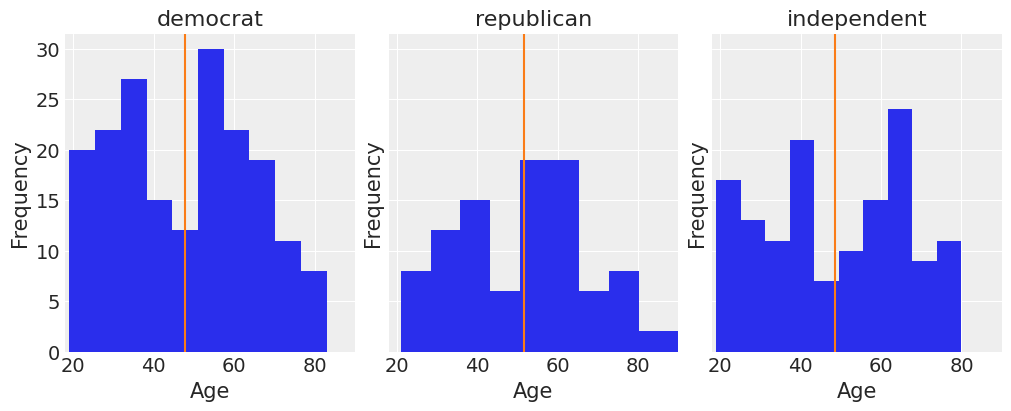

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(10, 4), sharey=True, constrained_layout=True)
key = dict(zip(data["party_id"].unique(), range(3)))
for label, df in data.groupby("party_id"):
    ax[key[label]].hist(df["age"])
    ax[key[label]].set_xlim([18, 90])
    ax[key[label]].set_xlabel("Age")
    ax[key[label]].set_ylabel("Frequency")
    ax[key[label]].set_title(label)
    ax[key[label]].axvline(df["age"].mean(), color="C1")

In [9]:
pd.crosstab(data["vote"], data["party_id"])

party_id,democrat,independent,republican
vote,,,
clinton,159,51,5
someone_else,10,22,16
trump,17,65,76


In [10]:
pd.crosstab(data["vote"], data["age"])

age,19,20,21,22,23,24,25,26,27,28,...,77,78,79,80,81,82,83,84,91,95
vote,,,,,,,,,,,,,,,,,,,,,
clinton,1,6,6,6,0,4,5,3,4,5,...,1,2,1,2,1,1,1,0,0,0
someone_else,1,1,0,1,1,0,0,2,0,1,...,0,2,0,1,0,0,0,0,0,0
trump,0,1,1,0,3,3,1,1,3,4,...,2,1,1,1,0,0,1,1,1,1


# Build clinton_model

In [12]:
clinton_data = data.loc[data["vote"].isin(["clinton", "trump"]), :]
clinton_data.head()

,vote,age,party_id
0,clinton,56,democrat
1,trump,65,republican
2,clinton,80,democrat
3,trump,38,republican
4,trump,60,republican


In [13]:
clinton_model = bmb.Model("vote['clinton'] ~ party_id + party_id:age", clinton_data, family="bernoulli")
clinton_fitted = clinton_model.fit(draws=2000, target_accept=0.85, random_seed=SEED)

Modeling the probability that vote==clinton
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, party_id, party_id:age]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


In [14]:
clinton_model

Formula: vote['clinton'] ~ party_id + party_id:age
Family name: Bernoulli
Link: logit
Observations: 373
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 4.3846)
    party_id ~ Normal(mu: [0. 0.], sigma: [5.4007 6.0634])
    party_id:age ~ Normal(mu: [0. 0. 0.], sigma: [0.0938 0.1007 0.1098])
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'party_id:age\ndemocrat'}>,
        <AxesSubplot:title={'center':'party_id:age\nindependent'}>],
       [<AxesSubplot:title={'center':'party_id:age\nrepublican'}>,
        <AxesSubplot:title={'center':'party_id\nindependent'}>,
        <AxesSubplot:title={'center':'party_id\nrepublican'}>]],
      dtype=object)

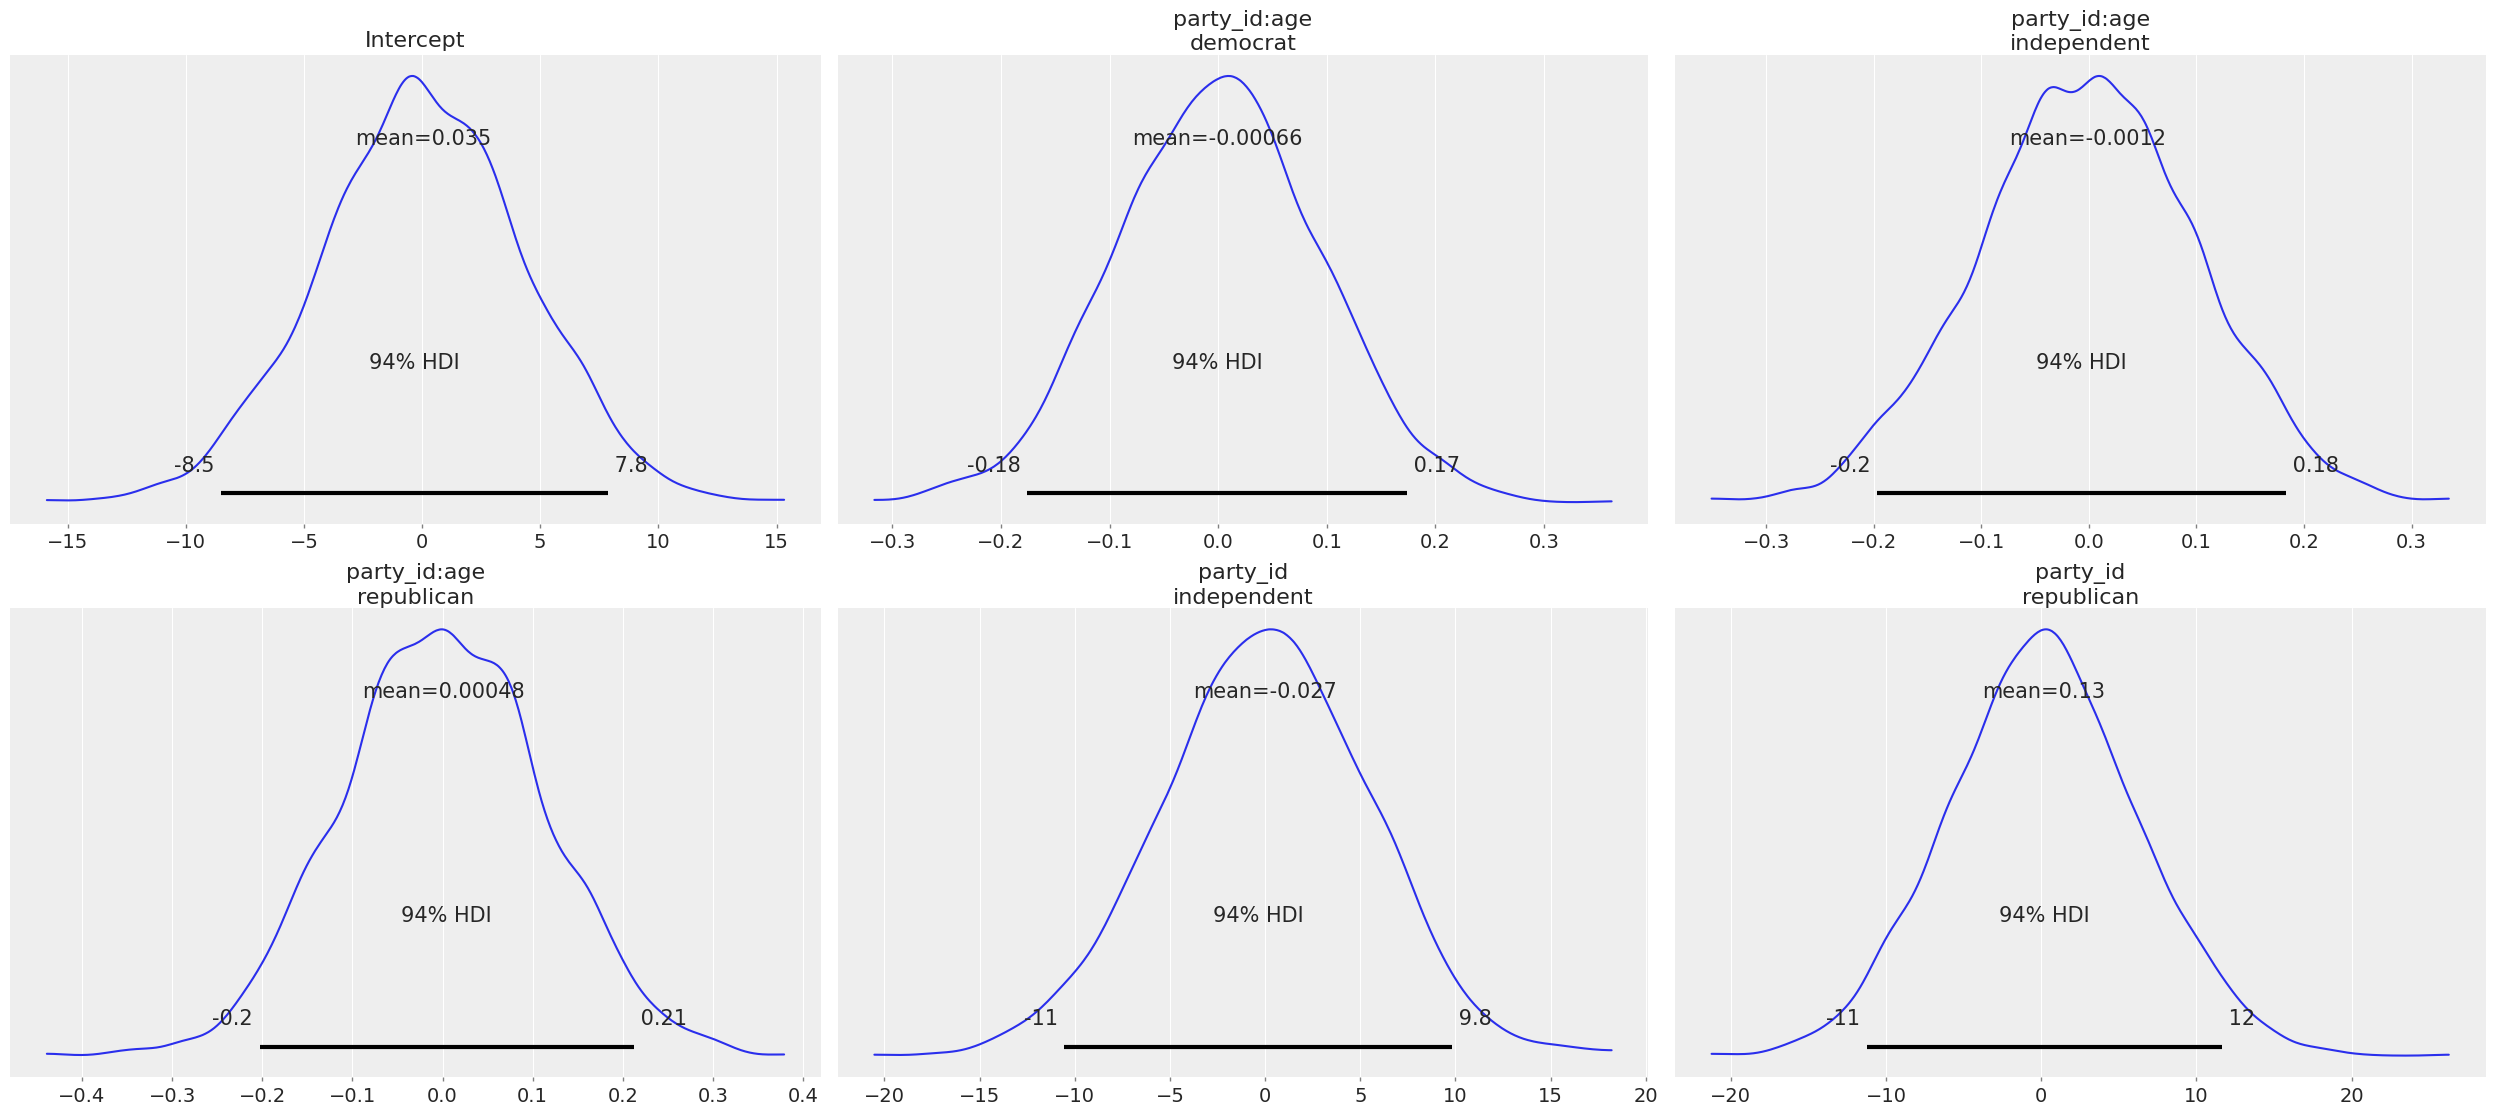

In [15]:
clinton_model.plot_priors()

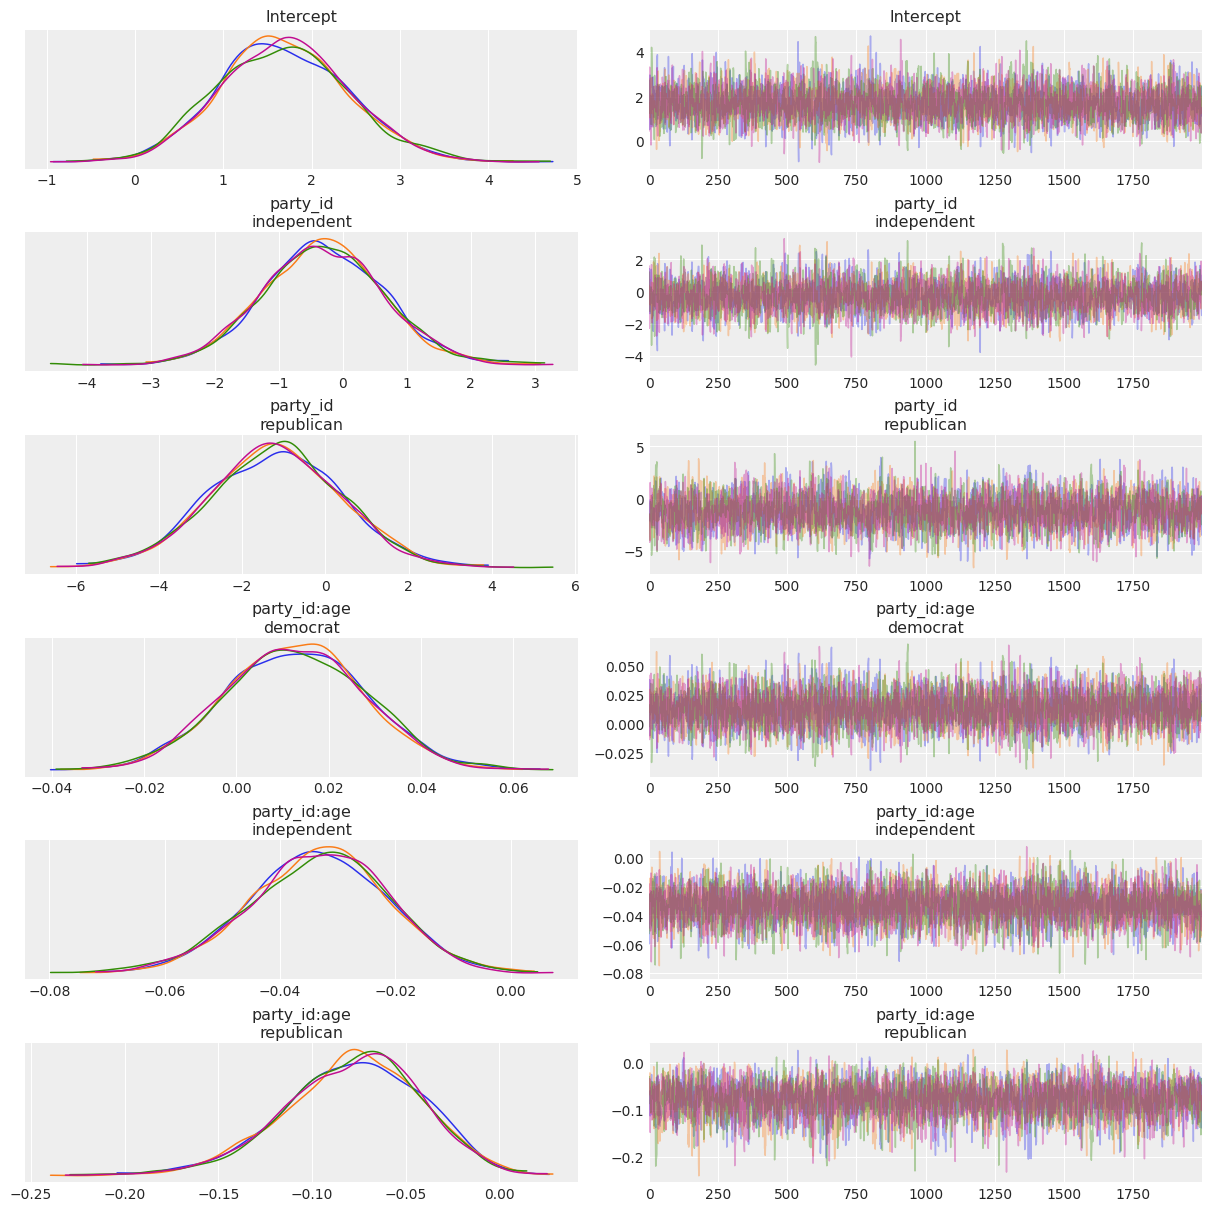

In [16]:
az.plot_trace(clinton_fitted, compact=False);

In [17]:
az.summary(clinton_fitted)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.691,0.735,0.348,3.075,0.010,0.007,5577.0,4728.0,1.0
party_id[independent],-0.305,0.949,-2.099,1.469,0.014,0.013,4648.0,4511.0,1.0
party_id[republican],-1.203,1.582,-4.184,1.777,0.026,0.018,3804.0,4129.0,1.0
party_id:age[democrat],0.013,0.015,-0.016,0.040,0.000,0.000,5588.0,4750.0,1.0
party_id:age[independent],-0.033,0.012,-0.056,-0.012,0.000,0.000,5777.0,4971.0,1.0
party_id:age[republican],-0.079,0.037,-0.146,-0.010,0.001,0.000,3861.0,3418.0,1.0


# Model assessment

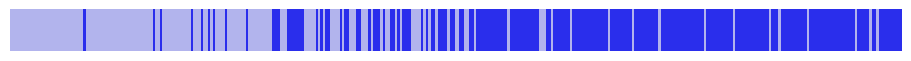

In [20]:
clinton_model.predict(clinton_fitted, kind="pps")
# plot separation plot
ax = az.plot_separation(clinton_fitted, y='vote', figsize=(9,0.5));

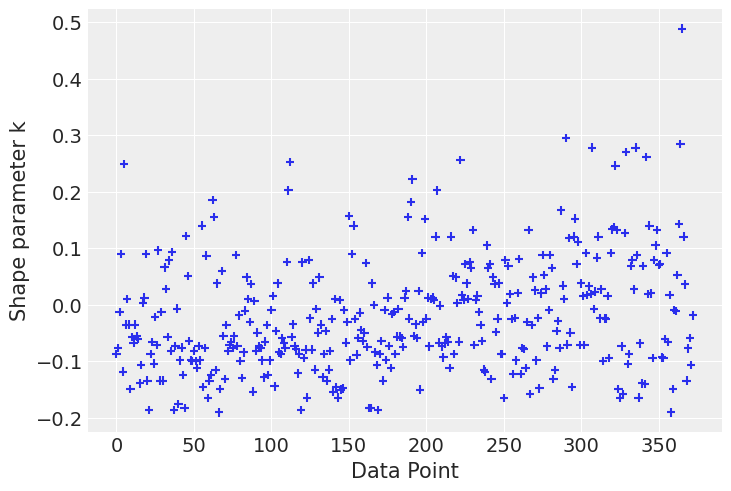

In [19]:
# compute pointwise LOO
loo = az.loo(clinton_fitted, pointwise=True)
# plot kappa values
az.plot_khat(loo.pareto_k);

### Observations with highest kappa

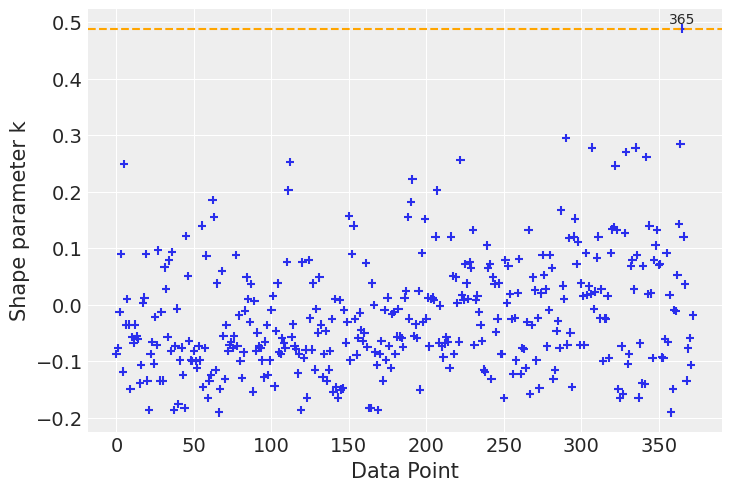

In [21]:
ax = az.plot_khat(loo.pareto_k.values.ravel())
sorted_kappas = np.sort(loo.pareto_k.values.ravel())

# find observation where the kappa value exceeds the threshold
threshold = sorted_kappas[-1:]
ax.axhline(threshold, ls="--", color="orange")
influential_observations = clinton_data.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [22]:
clinton_data.reset_index()[loo.pareto_k.values >= threshold]

,index,vote,age,party_id
365,410,clinton,55,republican


### Observations with highest kappa

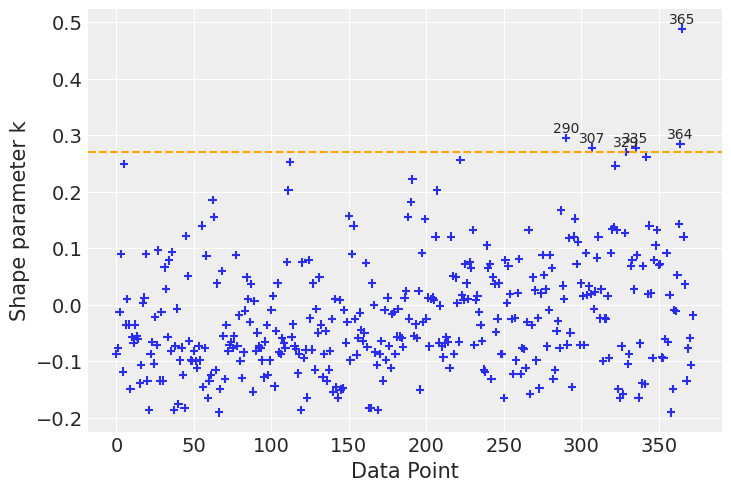

In [23]:
ax = az.plot_khat(loo.pareto_k)

# find observation where the kappa value exceeds the threshold
threshold = sorted_kappas[-6:].min()
ax.axhline(threshold, ls="--", color="orange")
influential_observations = clinton_data.reset_index()[loo.pareto_k.values >= threshold].index

for x in influential_observations:
    y = loo.pareto_k.values[x]
    ax.text(x, y + 0.01, str(x), ha="center", va="baseline")

In [24]:
clinton_data.reset_index()[loo.pareto_k.values>=threshold]

,index,vote,age,party_id
290,326,trump,27,democrat
307,344,trump,28,democrat
329,369,trump,26,democrat
335,376,trump,28,democrat
364,409,trump,31,democrat
365,410,clinton,55,republican


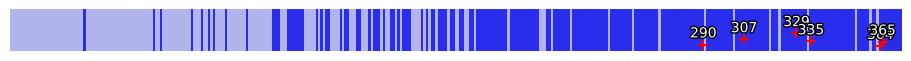

In [25]:
import matplotlib.patheffects as pe

ax = az.plot_separation(clinton_fitted, y="vote", figsize=(9, 0.5))

y = np.random.uniform(0.1, 0.5, size=len(influential_observations))

for x, y in zip(influential_observations, y):
    text = str(x)
    x = x / len(clinton_data)
    ax.scatter(x, y, marker="+", s=50, color="red", zorder=3)
    ax.text(
        x, y + 0.1, text, color="white", ha="center", va="bottom",
        path_effects=[pe.withStroke(linewidth=2, foreground="black")]
    )

In [26]:
clinton_data.reset_index()[loo.pareto_k.values>=threshold]

,index,vote,age,party_id
290,326,trump,27,democrat
307,344,trump,28,democrat
329,369,trump,26,democrat
335,376,trump,28,democrat
364,409,trump,31,democrat
365,410,clinton,55,republican


# Run Inference

In [27]:
parties = ["democrat", "independent", "republican"]
dem, ind, rep = [clinton_fitted.posterior["party_id:age"].sel({"party_id:age_dim":party}) for party in parties]

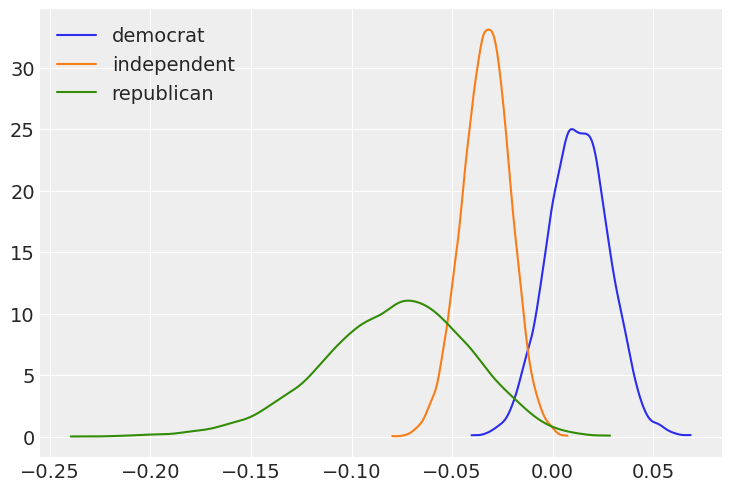

In [28]:
_, ax = plt.subplots()
for idx, x in enumerate([dem, ind, rep]):
    az.plot_dist(x, label=x["party_id:age_dim"].item(), plot_kwargs={"color": f"C{idx}"}, ax=ax)
ax.legend(loc="upper left");

In [29]:
(dem > rep).mean().item()

0.995625

In [30]:
(dem > ind).mean().item()

0.992125

In [31]:
(ind > rep).mean().item()

0.880375

In [32]:
(dem > 0).mean().item()

0.796375

In [33]:
(rep < 0).mean().item()

0.9925

In [34]:
(ind < 0).mean().item()

0.998625

# Spaghetti plot of model predictions

In [35]:
age = np.arange(18, 91)
new_data = pd.DataFrame({
    "age": np.tile(age, 3),
    "party_id": np.repeat(["democrat", "republican", "independent"], len(age))
})
new_data

,age,party_id
0,18,democrat
1,19,democrat
2,20,democrat
3,21,democrat
4,22,democrat
...,...,...
214,86,independent
215,87,independent
216,88,independent
217,89,independent


In [36]:
clinton_model.predict(clinton_fitted, data=new_data)
# Select a sample of posterior values for the mean probability of voting for Clinton
vote_posterior = az.extract_dataset(clinton_fitted, num_samples=2000)["vote_mean"]

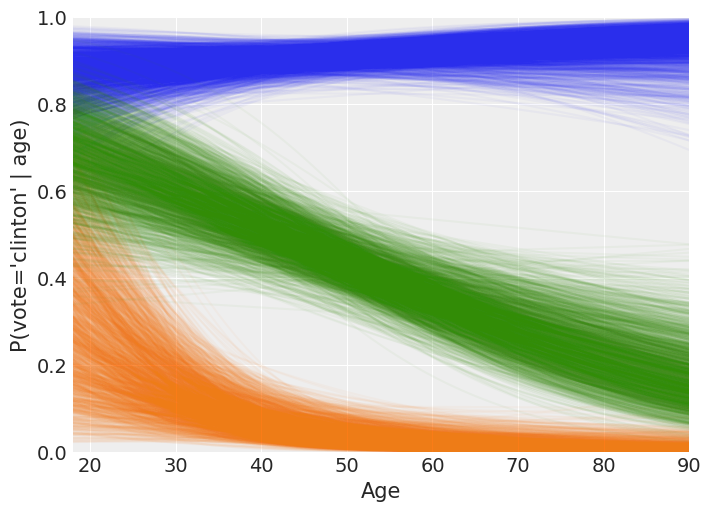

In [37]:
_, ax = plt.subplots(figsize=(7, 5))

for i, party in enumerate(["democrat", "republican", "independent"]):
    # Which rows in new_data correspond to party?
    idx = new_data.index[new_data["party_id"] == party].tolist()
    ax.plot(age, vote_posterior[idx], alpha=0.04, color=f"C{i}")

ax.set_ylabel("P(vote='clinton' | age)")
ax.set_xlabel("Age", fontsize=15)
ax.set_ylim(0, 1)
ax.set_xlim(18, 90);

In [39]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Aug 19 2022

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

arviz     : 0.12.1
numpy     : 1.21.6
pandas    : 1.4.3
matplotlib: 3.5.3
bambi     : 0.9.0

Watermark: 2.3.1

